<a href="https://colab.research.google.com/github/cristhianaalbert/Poresolution_code/blob/Machine-learning-models/ML_models_Ca_all_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

In [ ]:
!pip install requests==2.23.0 folium==0.2.1 imgaug==0.2.6 pycaret pandas shap 
from pycaret.utils import enable_colab
enable_colab()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.utils import check_metric
from pycaret.regression import *


     |████████████████████████████████| 69 kB 3.8 MB/s 
     |████████████████████████████████| 631 kB 17.1 MB/s 
     |████████████████████████████████| 320 kB 47.3 MB/s 
     |████████████████████████████████| 564 kB 47.9 MB/s 
     |████████████████████████████████| 88 kB 6.7 MB/s 
     |████████████████████████████████| 6.8 MB 39.5 MB/s 
     |████████████████████████████████| 2.0 MB 32.8 MB/s 
     |████████████████████████████████| 167 kB 46.9 MB/s 
     |████████████████████████████████| 261 kB 54.0 MB/s 
     |████████████████████████████████| 116 kB 42.7 MB/s 
     |████████████████████████████████| 16.8 MB 37.9 MB/s 
     |████████████████████████████████| 1.3 MB 35.5 MB/s 
     |████████████████████████████████| 1.7 MB 58.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |██████████████████

Colab mode enabled.


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
def count_alpha_error (a, alpha=0.1):

    '''Calculates the percentage of elements inside a +- alpha range around the true measured value of the ion;
     a = array with final predictions on unseen data;
     alpha = range of error
    '''
    error = a.Capredicted / a.Ca                           #when we are dealing with log scale of ion, the analysis is still in absolute terms;
    count = error[((1-alpha) < error) & (error <(1+alpha))].size
    total = len(error)
    return count/total

Load dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
#dataset = pd.read_csv(io.StringIO(uploaded['datasetMPKlogCa.csv'].decode('utf-8')))
dataset = pd.read_csv(io.StringIO(uploaded['database_Ca_1.csv'].decode('utf-8')),sep=',')

dataset.head()


Saving database_Ca_1.csv to database_Ca_1 (2).csv


,Index,Matrix_type,waterbinder,aggregatesbinder,Blend,PC,SCM1,SCM1_type,SCM2,SCM2_type,PC_CaO,PC_SiO2,PC_Al2O3,PC_Fe2O3,PC_SO3,PC_MgO,PC_Na2O,PC_K2O,PC_TiO2,PC_P2O5,PC_MnO,PC_CO2,PC_LOI,PC_Amorphous,PC_C3S,PC_C2S,PC_C3A,PC_C4AF,PC_Blaine,PC_BET,SCM1_CaO,SCM1_SiO2,SCM1_Al2O3,SCM1_Fe2O3,SCM1_SO3,SCM1_MgO,SCM1_Na2O,SCM1_K2O,SCM1_TiO2,SCM1_P2O5,SCM1_MnO,SCM1_CO2,SCM1_LOI,SCM1_Amorphous,SCM1_Blaine,SCM1_BET,SCM2_CaO,SCM2_SiO2,SCM2_Al2O3,SCM2_Fe2O3,SCM2_SO3,SCM2_MgO,SCM2_Na2O,SCM2_K2O,SCM2_TiO2,SCM2_P2O5,SCM2_MnO,SCM2_CO2,SCM2_LOI,SCM2_Amorphous,SCM2_Blaine,SCM2_BET,C1_Age_days,C1_Sealed,C1_RH,C1_T,C2_Age_days,C2_Sealed,C2_RH,C2_T,Final_age_days,logCa,Ca,Extraction,Pressure_MPa
0,9,1,0.5,0.0,2,0.53,0.47,3,0.00,0,62.1,20.37,5.56,2.49,3.54,1.65,0.07,0.65,0.29,0.14,0.05,NaN,1.99,NaN,58.1,14.3,9.2,6.7,5930.0,NaN,41.82,34.87,11.62,0.45,3.13,5.82,0.07,0.47,1.11,0.02,0.27,NaN,1.45,97.5,4540.0,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,28.0,1,NaN,20.0,0,0,0,0.0,28.0,0.10721,1.3,1,250.0
1,10,1,0.5,0.0,2,0.53,0.47,3,0.00,0,62.1,20.37,5.56,2.49,3.54,1.65,0.07,0.65,0.29,0.14,0.05,NaN,1.99,NaN,58.1,14.3,9.2,6.7,5930.0,NaN,41.82,34.87,11.62,0.45,3.13,5.82,0.07,0.47,1.11,0.02,0.27,NaN,1.45,97.5,4540.0,NaN,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,99.0,1,NaN,20.0,0,0,0,0.0,99.0,0.16732,1.5,1,250.0
2,19,1,0.5,0.0,3,0.53,0.38,3,0.09,5,62.1,20.37,5.56,2.49,3.54,1.65,0.07,0.65,0.29,0.14,0.05,NaN,1.99,NaN,58.1,14.3,9.2,6.7,5930.0,NaN,41.82,34.87,11.62,0.45,3.13,5.82,0.07,0.47,1.11,0.02,0.27,NaN,1.45,97.5,4540.0,NaN,53.13,2.0,0.8,0.32,0.07,0.64,NaN,0.1,0.04,0.04,0.03,NaN,42.3,2.0,3280.0,NaN,28.0,1,NaN,20.0,0,0,0,0.0,28.0,0.12710,1.3,1,250.0
3,20,1,0.5,0.0,3,0.53,0.38,3,0.09,5,62.1,20.37,5.56,2.49,3.54,1.65,0.07,0.65,0.29,0.14,0.05,NaN,1.99,NaN,58.1,14.3,9.2,6.7,5930.0,NaN,41.82,34.87,11.62,0.45,3.13,5.82,0.07,0.47,1.11,0.02,0.27,NaN,1.45,97.5,4540.0,NaN,53.13,2.0,0.8,0.32,0.07,0.64,NaN,0.1,0.04,0.04,0.03,NaN,42.3,2.0,3280.0,NaN,99.0,1,NaN,20.0,0,0,0,0.0,99.0,0.12385,1.3,1,250.0
4,29,1,0.5,0.0,3,0.53,0.38,3,0.09,7,62.1,20.37,5.56,2.49,3.54,1.65,0.07,0.65,0.29,0.14,0.05,NaN,1.99,NaN,58.1,14.3,9.2,6.7,5930.0,NaN,41.82,34.87,11.62,0.45,3.13,5.82,0.07,0.47,1.11,0.02,0.27,NaN,1.45,97.5,4540.0,NaN,0.00,100.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,NaN,NaN,28.0,1,NaN,20.0,0,0,0,0.0,28.0,0.17609,1.5,1,250.0


Visualize data

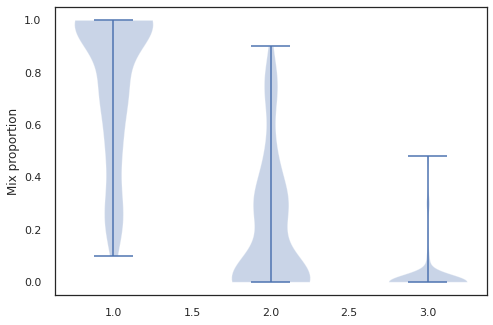

In [ ]:
## combine these different collections into a list
mixproportion = [dataset.PC, dataset.SCM1, dataset.SCM2]
#mixproportion = [dataset.waterbinder]
sns.set_theme(style="white")

# Create a figure instance
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Mix proportion')
#ax.set_xlabel('Sample name') ['PC', 'SCM1', 'SCM2', 'w/b'] LEARN HOW TO SET THESE AXIS
# Create the boxplot
bp = ax.violinplot(mixproportion)
plt.show()

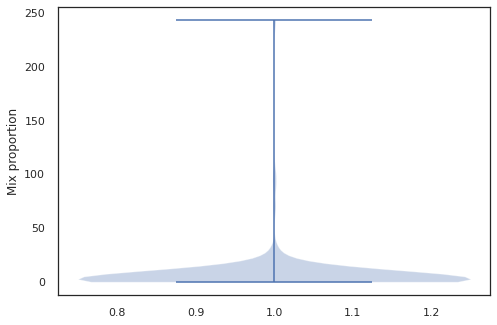

In [ ]:
## combine these different collections into a list
mixproportion = [10**dataset.logCa]
#mixproportion = [dataset.waterbinder]
sns.set_theme(style="white")

# Create a figure instance
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Mix proportion')
#ax.set_xlabel('Sample name') ['PC', 'SCM1', 'SCM2', 'w/b'] LEARN HOW TO SET THESE AXIS
# Create the boxplot
bp = ax.violinplot(mixproportion)
plt.show()

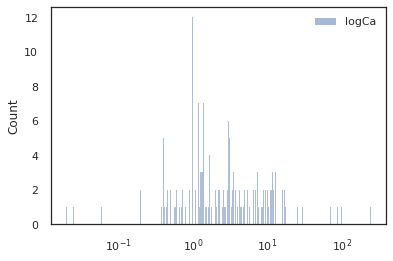

In [ ]:
fig, ax = plt.subplots()
sns.set_theme(style="white")
#sns.set_palette(sns.color_palette('Paired'))
mixproportion = [10**dataset.logCa]
sns.histplot(data=mixproportion, binwidth=0.01, log_scale=True,color='r', legend='Ca')
#ax1.set_ylim(0, 30)
#plt.setp(ax, xticks=[10,100,1000])


In [ ]:
display(dataset.shape)
dataset.describe()


(199, 75)

,Index,Matrix_type,waterbinder,aggregatesbinder,Blend,PC,SCM1,SCM1_type,SCM2,SCM2_type,PC_CaO,PC_SiO2,PC_Al2O3,PC_Fe2O3,PC_SO3,PC_MgO,PC_Na2O,PC_K2O,PC_TiO2,PC_P2O5,PC_MnO,PC_CO2,PC_LOI,PC_Amorphous,PC_C3S,PC_C2S,PC_C3A,PC_C4AF,PC_Blaine,PC_BET,SCM1_CaO,SCM1_SiO2,SCM1_Al2O3,SCM1_Fe2O3,SCM1_SO3,SCM1_MgO,SCM1_Na2O,SCM1_K2O,SCM1_TiO2,SCM1_P2O5,SCM1_MnO,SCM1_CO2,SCM1_LOI,SCM1_Amorphous,SCM1_Blaine,SCM1_BET,SCM2_CaO,SCM2_SiO2,SCM2_Al2O3,SCM2_Fe2O3,SCM2_SO3,SCM2_MgO,SCM2_Na2O,SCM2_K2O,SCM2_TiO2,SCM2_P2O5,SCM2_MnO,SCM2_CO2,SCM2_LOI,SCM2_Amorphous,SCM2_Blaine,SCM2_BET,C1_Age_days,C1_Sealed,C1_RH,C1_T,C2_Age_days,C2_Sealed,C2_RH,C2_T,Final_age_days,logCa,Ca,Extraction,Pressure_MPa
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,188.000000,188.000000,192.000000,192.000000,192.000000,163.000000,159.000000,172.000000,63.000000,56.000000,46.000000,52.000000,137.000000,0.0,150.00000,150.000000,150.000000,150.000000,108.000000,0.0,181.000000,176.000000,181.000000,176.000000,181.000000,161.000000,156.000000,168.000000,122.000000,116.000000,105.000000,94.000000,154.000000,88.000000,115.000000,80.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,195.000000,199.000000,193.000000,186.000000,193.000000,188.0,198.000000,186.000000,184.000000,180.0,199.000000,199.000000,43.000000,143.000000,199.000000,199.000000,199.000000,168.000000,199.000000,199.000000,199.000000,199.000000,121.000000
mean,489.236181,1.060302,0.493668,0.226131,1.738693,0.775226,0.202312,1.376884,0.022764,0.386935,61.884521,19.908936,4.574531,2.782760,4.076771,1.973067,0.236541,0.594942,0.122222,0.053750,0.020000,0.487500,2.695255,NaN,61.39040,14.006933,6.677467,8.661867,4173.425926,NaN,13.639884,30.813409,6.281265,0.784324,0.570166,1.984621,0.157128,0.310357,0.216557,0.004310,0.063810,1.356383,2.138052,10.000000,1600.956522,2597.500000,2.479598,4.235678,1.165327,0.201910,0.030854,0.310854,0.020923,0.114523,0.017254,0.000860,0.005751,0.0,0.920909,0.043011,71.304348,0.0,146.597990,0.934673,83.000000,22.699301,29.994975,0.010050,25.125628,2.321429,176.592965,0.388764,6.726357,1.010050,420.000000
std,305.379214,0.238645,0.139484,0.950343,0.652935,0.275097,0.250141,1.436771,0.082271,1.195966,6.310959,3.747861,5.705707,1.148628,5.663063,1.017242,0.191321,0.346446,0.122322,0.057003,0.028597,0.751758,3.003784,NaN,7.63085,3.446012,2.227961,2.963381,1056.392346,NaN,22.669302,37.002678,14.996467,1.946323,0.974724,3.251996,0.391151,0.566962,0.396922,0.008259,0.219402,7.510431,7.836832,29.798172,2529.150393,23232.746286,10.280406,15.961592,4.930697,0.932707,0.157341,1.346792,0.109442,0.551334,0.089024,0.005818,0.027034,0.0,5.968623,0.290906,479.629222,0.0,499.366072,0.247725,17.928429,8.665973,78.002428,0.099997,43.482950,6.540817,496.661176,0.572386,20.322792,0.099997,127.773758
min,9.000000,1.000000,0.310000,0.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,18.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,NaN,24.73000,7.460000,2.240000,0.970000,2800.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,50.000000,5.000000,0.000000,0.000000,0.000000,0.000000,28.000000,-1.698970,0.020000,1.000000,170.000000
25%,199.500000,1.000000,0.400000,0.000000,1.000000,0.600000,0.000000,0.000000,0.000000,0.000000,62.100000,18.940000,3.445000,2.310000,2.230000,1.220000,0.080000,0.290000,0.000000,0.000000,0.000000,0.000000,1.060000,NaN,58.00000,12.210000,4.040000,6.700000,3540.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

# Modeling

In [ ]:
#defining initial parameters

model_list = ['rf','et']                        #models to be tested;
seed_list = [76,89,140,267,870]                       #seeds for separating data to train/test model and for final predictions; 
sid_list = [22,453,563,914]                         #seeds for session id on setup - I believe it defines how cross-validation groups are defined;
featsel_list = [1.0, 0.4, 0.3,0.2,0.15]         #feature_selection_threshold for setup - defines how many features will be considered in the model (train/test/prediction);
featsel_list = [1.0]         #feature_selection_threshold for setup - defines how many features will be considered in the model (train/test/prediction);
seed_list = [20, 76,89,140,267,310, 560, 771, 870, 952]                       #seeds for separating data to train/test model and for final predictions; 
sid_list = [22,120, 200, 420, 453, 563, 680, 739, 810, 914]                         #seeds for session id on setup - I believe it defines how cross-validation groups are defined;
kfold_list = [5]                            #numbers of folds for cross-validation - I didn't notice differences on the final results;


alpha1=0.1                                   #error range - used to evaluate +-10% error of prediction around the measured value;
alpha2=0.25                                  #error range - used to evaluate +-25% error of prediction around the measured value;
i=0                                          #initial index;

#tunemodel
tune_on = 1   # 1 to avoid tuning of hyperparameteres; 2 to allow tuning of hyperparameteres;
#These parameters are focused on decision tree methods;
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
tune_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
                        

totalsystems = len(model_list)*len(seed_list)*len(sid_list)*len(featsel_list)*len(kfold_list)*tune_on   #total number of systems considering all variables; times 2 because we have tuned models
totalcolumns = 10                                                                                 #depends on the statistic variables stored on the array "summary" (modelname, ..., R2, RMSE, alpha, etc)
summary = np.zeros((totalsystems, totalcolumns),dtype=object)                                     #array summary mentioned above;

#REMEMBER TO ALTER DEPENDING ON THE SIZE OF DATASET (HOW MANY VARIABLES IT HAS)
estimativefeat = round(int(2*dataset.shape[1]))                        #depends on the number of features in dataset - needs to be a little bit bigger to account for categorical features that are transformed (one hot encoding method)
mostimpfeat = 10                           #number of most important features to be analysed; 15 or 10 seems a reasonable number;


mostimpfeat_value = np.ndarray(shape=(totalsystems, mostimpfeat+1),dtype=object)                      #arrays to store most important features properties; plus 1 is for indexing modelname
mostimpfeat_name = np.zeros(shape=(totalsystems, mostimpfeat+1),dtype=object)
mostimpfeat_test = np.zeros(shape=(totalsystems, 2*mostimpfeat+1),dtype=object)

feat_summary=[]

mostimpfeat_value_full = np.zeros(shape=(totalsystems, estimativefeat),dtype=float)               #arrays to store all features properties
mostimpfeat_name_full = np.zeros(shape=(totalsystems, estimativefeat),dtype=object)
mostimpfeat_full_summary = []


#numfeat = ['SCM2_Amorphous','C1_T','C2_Age_days','C2_T','Pressure_MPa']
ignfeat = ['Index',"Ca"]
numfeat = ['waterbinder','aggregatesbinder',
           'PC','SCM1','SCM2','PC_CaO','PC_SiO2','PC_Al2O3', 'PC_Fe2O3', 'PC_SO3', 'PC_MgO', 'PC_Na2O', 'PC_K2O', 
           'PC_TiO2', 'PC_P2O5', 'PC_MnO', 'PC_CO2','PC_LOI', 'PC_Amorphous', 'PC_C3S', 'PC_C2S', 'PC_C3A', 'PC_C4AF','PC_Blaine','PC_BET',
           'SCM1_CaO',	'SCM1_SiO2',	'SCM1_Al2O3',	'SCM1_Fe2O3',	'SCM1_SO3',	'SCM1_MgO',	'SCM1_Na2O',	'SCM1_K2O',	
           'SCM1_TiO2',	'SCM1_P2O5',	'SCM1_MnO',	'SCM1_CO2',	'SCM1_LOI','SCM1_Amorphous','SCM1_Blaine','SCM1_BET',
           'SCM2_CaO',	'SCM2_SiO2',	'SCM2_Al2O3',	'SCM2_Fe2O3',	'SCM2_SO3',	'SCM2_MgO',	'SCM2_Na2O',	'SCM2_K2O',	
           'SCM2_TiO2',	'SCM2_P2O5',	'SCM2_MnO',	'SCM2_CO2',	'SCM2_LOI','SCM2_Amorphous','SCM2_Blaine','SCM2_BET',
           'C1_Age_days','C1_RH','C1_T','C2_Age_days','C2_RH','C2_T','Final_age_days','Pressure_MPa']

#numfeat = ['PC','SCM1','SCM2','PC_Na2O', 'PC_K2O','SCM1_SiO2','SCM2_SiO2','Final_age_days']



for modelname in model_list:                                #running for different models at same loop;
  for p in range(tune_on):                                                                                          #creating a normal and tuned version of the model  %TO AVOID HAVING TUNED MODELS, JUST PUT THE RANGE TO 1 INSTEAD OF 2

    for seed in seed_list:                                                                                      #running for different initial seeds for ramdom state - separation of data to train/test model and for final predictions;
      data = dataset.sample(frac=0.85, random_state=seed)
      data_unseen = dataset.drop(data.index)
      data.reset_index(drop=True, inplace=True)
      data_unseen.reset_index(drop=True, inplace=True)

      for sid in sid_list:                                                                                      #running for different seeds for session id on setup - I believe it defines how cross-validation groups are defined;
        for featsel in featsel_list:                                                                            #running different feature_selection_threshold for setup - defines how many features will be considered in the model (train/test/prediction)

          exp_ps = setup(data = data, target = 'logCa', session_id=sid, normalize = True, 
                        combine_rare_levels = True, rare_level_threshold = 0.05,
                        remove_outliers = True, log_experiment = True, experiment_name = 'poresolution',
                        numeric_features = numfeat, fold=5, ignore_features = ignfeat,
                        feature_selection = True, silent=True, verbose=False)

          for kfold in kfold_list:                          #running for different numbers of folds for cross-validation - I didn't notice differences on the final results;
            #model = create_model(modelname,fold=kfold, n_estimators=80,max_depth=10, verbose=False)
            model = create_model(modelname,n_estimators=80,max_depth=8,fold=kfold,verbose=False)


            if p == 0:                                      #normal model
              model = model           
              modelnameb = modelname

            if p == 1:                                      #tuned model
              model = tune_model(model,fold=kfold, optimize="RMSE", verbose=False)
              modelnameb = 'tuned_'+str(modelname)
            
            aaa=get_logs()

            final_model = finalize_model(model)
            unseen_predictions = predict_model(final_model, data=data_unseen, round=None)
            #test_predictions = predict_model(final_model, data=data_testprediction, round=None)

            #checking accuracy of predictions on unseen data - R2, RMSE, fraction of predictions within alpha error range;
            a = unseen_predictions
            alinear = pd.DataFrame([np.array(10**a.logCa), np.array(10**a.Label)]).T
            alinear.columns=["Ca","Capredicted"]            
            R2 = check_metric(alinear.Ca, alinear.Capredicted, 'R2' )     
            RMSE = check_metric(alinear.Ca, alinear.Capredicted, 'RMSE' )
            erroralpha1 = count_alpha_error(alinear, alpha1)
            erroralpha2 = count_alpha_error(alinear, alpha2)

            nfeat = get_config('X_train').shape[1]           #number of features considered by model - depends on feature_selection_threshold;               

            summary[i,:] = ([modelnameb, seed, sid, kfold, featsel,nfeat, R2, RMSE, erroralpha1, erroralpha2])     #storing all these metrics for each system;


            featimp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(final_model.feature_importances_)})    #getting the feature importance scores for all systems;
            featimpsort = featimp.sort_values(by='Value', ascending=False)[:mostimpfeat]                                           #organizing feature importance scores in descending order of importance;
            
            feat1 = np.array(featimpsort)[0,0]            #1st to 5th most important feature -> to be displayed during evaluations -> important to checks during runs;
            feat2 = np.array(featimpsort)[1,0]
            feat3 = np.array(featimpsort)[2,0]
            feat4 = np.array(featimpsort)[3,0]
            feat5 = np.array(featimpsort)[4,0]

            mostimpfeat_name[i][0] = modelnameb                                                      #indexing the modelnameb to later identify where did the features get the most contribution
            mostimpfeat_value[i][0] = modelnameb                                                     #indexing the modelnameb to later identify where did the features get the most contribution
            for j in range(mostimpfeat):                                                             #arranging names and values of most important features in two arrays; 
              mostimpfeat_name[i][j+1] = np.array(featimpsort)[j,0]                                  #feature name
              mostimpfeat_value[i][j+1] = np.array(featimpsort)[j,1]/np.array(featimpsort)[0,1]      #feature importance value normalized in relation to most important feature;

            mostimpfeat_test[i][0] = modelnameb                                                      #indexing the modelnameb to later identify where did the features get the most contribution
            for j in range(mostimpfeat):                                                             #arranging names and values of most important features in one array; -> best method;
              mostimpfeat_test[i][2*j+1] = np.array(featimpsort)[j,0]                                #feature name
              mostimpfeat_test[i][2*j+2] = np.array(featimpsort)[j,1]/np.array(featimpsort)[0,1]     #feature importance value normalized in relation to most important feature;



            for k in range(nfeat):                                                                   #arranging names and values of all features in two arrays; 
              mostimpfeat_name_full[i][k] = np.array(featimp)[k,0]                                   #feature name
              mostimpfeat_value_full[i][k] = np.array(featimp)[k,1]/np.array(featimpsort)[0,1]       #feature importance value normalized in relation to most important feature;


            
            for ida, system in enumerate(mostimpfeat_name_full):          #arranging names and values of most important features in one array; -> best method;
              for idb, name in enumerate(system):
                value = mostimpfeat_value_full[ida][idb]
                mostimpfeat_full_summary.append([ida,idb,name,value])      

            i=i+1                                                         #finishing round and going to next one; increasing index number accordingly;

        #print('random_state=',seed,'  session_id=',sid,'  kfold=',kfold,'  R2=', R2, '  RMSE=', RMSE)
            print('''model = {: <10}  random_state = {: <5}  sid = {: <5}  feat_sel_thresh = {: <5}  features = {:<5}  R2 = {:.3f}   RMSE = {:.3f}  Error_a1 = {:.3f}   Error_a2 = {:.3f}   Feat1 = {: <10}   Feat2 = {: <10}   Feat3 = {: <10}     Feat4 = {: <10}   Feat5 = {: <10}'''
                    .format(modelnameb,seed,sid,featsel, nfeat, R2, RMSE,erroralpha1, erroralpha2, feat1, feat2, feat3, feat4, feat5))

pd.DataFrame(mostimpfeat_test).to_csv('mostimpfeat_test.csv',index=False)

table_summary = pd.DataFrame(summary)                 #creating table of statistics for all systems;
table_summary.columns = ['model','random_state','sid','kfold','feat_sel_thresh','features','R2','RMSE','Error_alpha_0.1','Error_alpha_0.25']


columnname = []                                       #creating column names for most important features - we might change the number of selected features 
for i in range(mostimpfeat):
  columnname.append(str(i+1)+'N')
  columnname.append(str(i+1)+'V')

table_mostimpfeat = pd.DataFrame(mostimpfeat_test[:,1:])    #creating table of most important features with their name and value/score;
table_mostimpfeat.columns = columnname

finaltable = pd.concat([table_summary, table_mostimpfeat], axis=1, join='inner')   #combining statistics and most imp features in only one table; it helps on converting it to only one csv file later.
finaltable.to_csv('finaltable.csv')
display(finaltable)

model = rf          random_state = 20     sid = 22     feat_sel_thresh = 1.0    features = 64     R2 = 0.111   RMSE = 3.636  Error_a1 = 0.133   Error_a2 = 0.333   Feat1 = PC_SiO2      Feat2 = PC_LOI       Feat3 = PC_P2O5        Feat4 = waterbinder   Feat5 = PC_C4AF   
model = rf          random_state = 20     sid = 120    feat_sel_thresh = 1.0    features = 69     R2 = 0.021   RMSE = 3.816  Error_a1 = 0.167   Error_a2 = 0.400   Feat1 = PC_SiO2      Feat2 = PC_Fe2O3     Feat3 = waterbinder     Feat4 = PC_P2O5      Feat5 = Extraction_1
model = rf          random_state = 20     sid = 200    feat_sel_thresh = 1.0    features = 66     R2 = 0.137   RMSE = 3.583  Error_a1 = 0.233   Error_a2 = 0.333   Feat1 = PC_SiO2      Feat2 = waterbinder   Feat3 = PC_Fe2O3       Feat4 = PC_P2O5      Feat5 = PC_Al2O3  
model = rf          random_state = 20     sid = 420    feat_sel_thresh = 1.0    features = 73     R2 = 0.052   RMSE = 3.755  Error_a1 = 0.200   Error_a2 = 0.333   Feat1 = PC_LOI       Feat2 =

,model,random_state,sid,kfold,feat_sel_thresh,features,R2,RMSE,Error_alpha_0.1,Error_alpha_0.25,1N,1V,2N,2V,3N,3V,4N,4V,5N,5V,6N,6V,7N,7V,8N,8V,9N,9V,10N,10V
0,rf,20,22,5,1,64,0.111,3.6361,0.133333,0.333333,PC_SiO2,1,PC_LOI,0.593054,PC_P2O5,0.443049,waterbinder,0.403521,PC_C4AF,0.372086,Extraction_1,0.362668,PC_K2O,0.349244,PC_Fe2O3,0.344768,SCM1_SiO2,0.241984,PC_C3S,0.227113
1,rf,20,120,5,1,69,0.021,3.8158,0.166667,0.4,PC_SiO2,1,PC_Fe2O3,0.529171,waterbinder,0.434394,PC_P2O5,0.427766,Extraction_1,0.383824,PC_K2O,0.274356,PC_Al2O3,0.245847,SCM1_SiO2,0.196054,PC_CaO,0.186498,PC_MgO,0.159917
2,rf,20,200,5,1,66,0.1366,3.5834,0.233333,0.333333,PC_SiO2,1,waterbinder,0.601561,PC_Fe2O3,0.501258,PC_P2O5,0.470038,PC_Al2O3,0.38139,Extraction_2,0.357724,SCM1_SiO2,0.289483,PC_K2O,0.279999,PC_LOI,0.231675,PC_MgO,0.204281
3,rf,20,420,5,1,73,0.0522,3.7545,0.2,0.333333,PC_LOI,1,PC_SiO2,0.877119,waterbinder,0.616914,PC_Fe2O3,0.518676,PC_C4AF,0.497644,Extraction_1,0.494713,PC_P2O5,0.465182,SCM1_SiO2,0.39944,PC_K2O,0.394499,PC_Al2O3,0.367728
4,rf,20,453,5,1,71,0.0983,3.6621,0.2,0.366667,PC_SiO2,1,waterbinder,0.612651,PC_P2O5,0.47516,PC_Fe2O3,0.425987,Extraction_1,0.369093,PC_LOI,0.323348,PC_K2O,0.32027,SCM1_SiO2,0.306521,PC_Al2O3,0.298561,PC_CaO,0.234147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,et,952,563,5,1,65,0.1831,15.9822,0.166667,0.366667,C1_Sealed_0,1,SCM1_BET,0.76716,PC_SiO2,0.751133,waterbinder,0.540328,PC_P2O5,0.504412,PC_Al2O3,0.468767,PC_CaO,0.44238,Extraction_1,0.406227,PC_Fe2O3,0.323892,PC_K2O,0.200868
196,et,952,680,5,1,67,-0.0605,18.2105,0.233333,0.4,C1_Sealed_1,1,SCM1_BET,0.636999,waterbinder,0.558894,PC_SiO2,0.484223,PC_Al2O3,0.465648,PC_P2O5,0.364412,PC_LOI,0.287372,PC_CaO,0.286855,PC_Fe2O3,0.204416,Pressure_MPa,0.185546
197,et,952,739,5,1,64,0.1776,16.0359,0.233333,0.333333,C1_Sealed_1,1,PC_SiO2,0.805994,SCM1_BET,0.75945,PC_Al2O3,0.634265,waterbinder,0.542074,PC_Fe2O3,0.511709,PC_P2O5,0.50857,PC_CaO,0.506152,Extraction_1,0.384655,SCM1_SiO2,0.265208
198,et,952,810,5,1,68,0.3727,14.0053,0.2,0.333333,C1_Sealed_0,1,SCM1_BET,0.744209,PC_SiO2,0.698847,PC_Al2O3,0.624561,waterbinder,0.514011,PC_P2O5,0.487269,Extraction_1,0.435396,PC_CaO,0.336718,PC_LOI,0.277061,SCM1_SiO2,0.234707
